Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

![Credit card being held in hand](credit_card.jpg)

You have been provided with a small subset of the credit card applications a bank receives. The dataset has been loaded as a Pandas DataFrame for you. You will start from there. 

In [127]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,002 ...,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


# Summarise and split the data

In [128]:
cc_apps.describe()

,2,7,10,14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


# Drop unwanted features and split data

- for some reason the exercise relies on dropping features 11 and 13
- split data into test and training sets

In [129]:
# Drop features 11 and 13 using the drop() method as they are non-essential 
# for the task of this project.
cc_apps = cc_apps.drop([11, 13], axis=1)

# split the data into a test and training set
cc_apps_train, cc_apps_test = train_test_split(cc_apps, test_size=0.33, random_state=42)

# Handling the missing values

- missing data is a `?` symbol in the source data - we will convert that to a `np.NaN`
- Impute missing values as the mean for numeric data or most frequent for categorical. 

**Note** you must use numeric_only=True to avoid an error 

> TypeError: can only concatenate str (not "int") to str
>
This is an improvement / fix on the model solutionsolution


In [130]:
# Replace the '?'s with NaN in the train and test sets
cc_apps_train_nans_replaced = cc_apps_train.replace("?", np.NaN)
cc_apps_test_nans_replaced = cc_apps_test.replace("?", np.NaN)

# Impute the missing values with mean imputation
cc_apps_train_imputed = cc_apps_train_nans_replaced.fillna(cc_apps_train_nans_replaced.mean(numeric_only=True))
cc_apps_test_imputed = cc_apps_test_nans_replaced.fillna(cc_apps_train_nans_replaced.mean(numeric_only=True))

# Iterate over each column of cc_apps_train_imputed
for col in cc_apps_train_imputed.columns:
    # Check if the column is of object type
    if cc_apps_train_imputed[col].dtypes == "object":
        # Impute with the most frequent value from training data
        cc_apps_train_imputed = cc_apps_train_imputed.fillna(
            cc_apps_train_imputed[col].value_counts().index[0]
        )
        cc_apps_test_imputed = cc_apps_test_imputed.fillna(
            cc_apps_train_imputed[col].value_counts().index[0]
        )

In [131]:
cc_apps_train_imputed.head()

,0,1,2,3,4,5,6,7,8,9,10,12,14,15
382,a,24.33,2.500,y,p,i,bb,4.50,f,f,0,g,456,-
137,b,33.58,2.750,u,g,m,v,4.25,t,t,6,g,0,+
346,b,32.25,1.500,u,g,c,v,0.25,f,f,0,g,122,-
326,b,30.17,1.085,y,p,c,v,0.04,f,f,0,g,179,-
33,a,36.75,5.125,u,g,e,v,5.00,t,f,0,g,4000,+


# Encode the categorical features

- We need to one hot encode the categorical features which we do simply using `get_dummies` [from pandas](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) - typically we want to use `OneHotEncoder` for proper ML [as per this post](https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki)
- We also need to reindex the test data so it aligns to the training set and in doing so handle categories in the test data only

In [132]:
# Convert the categorical features in the train and test sets independently
cc_apps_train_cat_encoding = pd.get_dummies(cc_apps_train_imputed)
cc_apps_test_cat_encoding = pd.get_dummies(cc_apps_test_imputed)

# Reindex cc_apps_test_cat_encoding with columns from cc_apps_train_cat_encoding, 
# filling missing columns with 0s.
# This reindexing step is used for discarding any new categorical feature that appears in the 
# test data but not the training data.
cc_apps_test_cat_encoding = cc_apps_test_cat_encoding.reindex(
    columns=cc_apps_train_cat_encoding.columns, fill_value=0
)

In [133]:
cc_apps_train_cat_encoding.head()

,2,7,10,14,0_a,0_b,1_13.75,1_15.83,1_15.92,1_16.00,...,6_z,8_f,8_t,9_f,9_t,12_g,12_p,12_s,15_+,15_-
382,2.500,4.50,0,456,True,False,False,False,False,False,...,False,True,False,True,False,True,False,False,False,True
137,2.750,4.25,6,0,False,True,False,False,False,False,...,False,False,True,False,True,True,False,False,True,False
346,1.500,0.25,0,122,False,True,False,False,False,False,...,False,True,False,True,False,True,False,False,False,True
326,1.085,0.04,0,179,False,True,False,False,False,False,...,False,True,False,True,False,True,False,False,False,True
33,5.125,5.00,0,4000,True,False,False,False,False,False,...,False,False,True,True,False,True,False,False,True,False


# Segregate features and labels into separate variables

In [134]:
X_train, y_train = (
    cc_apps_train_cat_encoding.iloc[:, :-2].values,
    cc_apps_train_cat_encoding.iloc[:, [-1]].values,
)
X_test, y_test = (
    cc_apps_test_cat_encoding.iloc[:, :-2].values,
    cc_apps_test_cat_encoding.iloc[:, [-1]].values,
)

# Scale the data

In [135]:
# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

# Train a logistic regression classifier

In [136]:
# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

# Fit logreg to the train set
logreg.fit(rescaledX_train, y_train)

/Users/edoatley/source/ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

# Check the performance of the model

In [137]:
# Use logreg to predict instances from the test set and store it
y_pred = logreg.predict(rescaledX_test)

# Print the confusion matrix of the logreg model
print(confusion_matrix(y_test, y_pred))

[[ 94   9]
 [ 25 100]]


# Perform hyperparameter tuning 

In [138]:
# Define the grid of values for tol and max_iter
tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]

# Create a dictionary where tol and max_iter are keys and the lists of their values are the corresponding values
param_grid = dict(tol=tol, max_iter=max_iter)

# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)

# Fit grid_model to the data
grid_model_result = grid_model.fit(rescaledX_train, y_train)

/Users/edoatley/source/ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/edoatley/source/ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/edoatley/source/ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/edoatley/source/ml/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

# Get the results

In [139]:
# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

# Extract the best model and evaluate it on the test set
best_model = grid_model_result.best_estimator_
print(
    "Accuracy of logistic regression classifier: ",
    best_model.score(rescaledX_test, y_test),
)


Best: 0.867882 using {'max_iter': 100, 'tol': 0.01}
Accuracy of logistic regression classifier:  0.8508771929824561


# Conclusion

Interestingly this model gives a perfect result which is much better than I managed. Perhaps removing features 11 and 13 works some magic!! The features in the model here maybe are different? Let's run all the steps in the model solution and look at what they are doing (I change `cc` to `e`):

In [140]:
# Load dataset
ed_apps = pd.read_csv("cc_approvals.data", header=None)

# Drop the features 11 and 13
ed_apps = ed_apps.drop([11, 13], axis=1)

# Split into train and test sets
ed_apps_train, ed_apps_test = train_test_split(ed_apps, test_size=0.33, random_state=42)

# Replace the '?'s with NaN in the train and test sets
ed_apps_train_nans_replaced = ed_apps_train.replace("?", np.NaN)
ed_apps_test_nans_replaced = ed_apps_test.replace("?", np.NaN)

# Impute the missing values with mean imputation
ed_apps_train_imputed = ed_apps_train_nans_replaced.fillna(ed_apps_train_nans_replaced.mean(numeric_only=True))
ed_apps_test_imputed = ed_apps_test_nans_replaced.fillna(ed_apps_train_nans_replaced.mean(numeric_only=True))

# Iterate over each column of ed_apps_train_imputed
for col in ed_apps_train_imputed.columns:
    # Check if the column is of object type
    if ed_apps_train_imputed[col].dtypes == "object":
        # Impute with the most frequent value
        ed_apps_train_imputed = ed_apps_train_imputed.fillna(
            ed_apps_train_imputed[col].value_counts().index[0]
        )
        ed_apps_test_imputed = ed_apps_test_imputed.fillna(
            ed_apps_train_imputed[col].value_counts().index[0]
        )

# Convert the categorical features in the train and test sets independently
ed_apps_train_cat_encoding = pd.get_dummies(ed_apps_train_imputed)
ed_apps_test_cat_encoding = pd.get_dummies(ed_apps_test_imputed)

# Reindex the columns of the test set aligning with the train set
ed_apps_test_cat_encoding = ed_apps_test_cat_encoding.reindex(
    columns=cc_apps_train_cat_encoding.columns, fill_value=0
)

# Segregate features and labels into separate variables
ed_X_train, ed_y_train = (
    ed_apps_train_cat_encoding.iloc[:, :-1].values,
    ed_apps_train_cat_encoding.iloc[:, [-1]].values,
)
ed_X_test, ed_y_test = (
    ed_apps_test_cat_encoding.iloc[:, :-1].values,
    ed_apps_test_cat_encoding.iloc[:, [-1]].values,
)

Let's look at the head of the test and train data after splitting using `train_test_split`

In [141]:
ed_apps_test.head()

,0,1,2,3,4,5,6,7,8,9,10,12,14,15
286,a,?,1.5,u,g,ff,ff,0.0,f,t,2,g,105,-
511,a,46.00,4.0,u,g,j,j,0.0,t,f,0,g,960,+
257,b,20.00,0.0,u,g,d,v,0.5,f,f,0,g,0,-
336,b,47.33,6.5,u,g,c,v,1.0,f,f,0,g,228,-
318,b,19.17,0.0,y,p,m,bb,0.0,f,f,0,s,1,+


In [142]:
ed_apps_train.head()

,0,1,2,3,4,5,6,7,8,9,10,12,14,15
382,a,24.33,2.500,y,p,i,bb,4.50,f,f,0,g,456,-
137,b,33.58,2.750,u,g,m,v,4.25,t,t,6,g,0,+
346,?,32.25,1.500,u,g,c,v,0.25,f,f,0,g,122,-
326,b,30.17,1.085,y,p,c,v,0.04,f,f,0,g,179,-
33,a,36.75,5.125,u,g,e,v,5.00,t,f,0,g,4000,+


So we can see the last column is 15 and this has the label as `+` or `-`. There follows handling missing values and categorical values. Let's look at the dta after those stages

In [143]:
ed_apps_train_cat_encoding.head()

,2,7,10,14,0_a,0_b,1_13.75,1_15.83,1_15.92,1_16.00,...,6_z,8_f,8_t,9_f,9_t,12_g,12_p,12_s,15_+,15_-
382,2.500,4.50,0,456,True,False,False,False,False,False,...,False,True,False,True,False,True,False,False,False,True
137,2.750,4.25,6,0,False,True,False,False,False,False,...,False,False,True,False,True,True,False,False,True,False
346,1.500,0.25,0,122,False,True,False,False,False,False,...,False,True,False,True,False,True,False,False,False,True
326,1.085,0.04,0,179,False,True,False,False,False,False,...,False,True,False,True,False,True,False,False,False,True
33,5.125,5.00,0,4000,True,False,False,False,False,False,...,False,False,True,True,False,True,False,False,True,False


In [144]:
ed_apps_test_cat_encoding.head()

,2,7,10,14,0_a,0_b,1_13.75,1_15.83,1_15.92,1_16.00,...,6_z,8_f,8_t,9_f,9_t,12_g,12_p,12_s,15_+,15_-
286,1.5,0.0,2,105,True,False,0,0,0,False,...,False,True,False,False,True,True,False,False,False,True
511,4.0,0.0,0,960,True,False,0,0,0,False,...,False,False,True,True,False,True,False,False,True,False
257,0.0,0.5,0,0,False,True,0,0,0,False,...,False,True,False,True,False,True,False,False,False,True
336,6.5,1.0,0,228,False,True,0,0,0,False,...,False,True,False,True,False,True,False,False,False,True
318,0.0,0.0,0,1,False,True,0,0,0,False,...,False,True,False,True,False,False,False,True,True,False


Notice the last two columns are`15_-` and  `15_+` which are the same as the `y` we are looking to predict the next step should lose these in the X_* variables. Lets see if that happens. It is a bit tricky to see this but we can compare row 1 of `ed_apps_train_cat_encoding` and `ed_X_train` - we could also just take it as a given as `ed_X_train` comes from `ed_apps_train_cat_encoding.iloc[:, :-1].values` and so only chops off the last column but you can see the code that follows prints last this:

```output
i=332 c=False 15_+
``````

In [145]:
ed_cols = ed_apps_train_cat_encoding.columns
for i,c in enumerate(ed_X_train[0]):
    print(f'{i=} {c=} {ed_cols[i]}')

i=0 c=2.5 2
i=1 c=4.5 7
i=2 c=0 10
i=3 c=456 14
i=4 c=True 0_a
i=5 c=False 0_b
i=6 c=False 1_13.75
i=7 c=False 1_15.83
i=8 c=False 1_15.92
i=9 c=False 1_16.00
i=10 c=False 1_16.08
i=11 c=False 1_16.25
i=12 c=False 1_16.33
i=13 c=False 1_16.50
i=14 c=False 1_16.92
i=15 c=False 1_17.08
i=16 c=False 1_17.25
i=17 c=False 1_17.42
i=18 c=False 1_17.50
i=19 c=False 1_17.58
i=20 c=False 1_17.67
i=21 c=False 1_17.83
i=22 c=False 1_17.92
i=23 c=False 1_18.00
i=24 c=False 1_18.08
i=25 c=False 1_18.17
i=26 c=False 1_18.25
i=27 c=False 1_18.33
i=28 c=False 1_18.42
i=29 c=False 1_18.58
i=30 c=False 1_18.67
i=31 c=False 1_18.75
i=32 c=False 1_18.83
i=33 c=False 1_18.92
i=34 c=False 1_19.00
i=35 c=False 1_19.17
i=36 c=False 1_19.33
i=37 c=False 1_19.42
i=38 c=False 1_19.50
i=39 c=False 1_19.58
i=40 c=False 1_19.67
i=41 c=False 1_20.00
i=42 c=False 1_20.08
i=43 c=False 1_20.17
i=44 c=False 1_20.25
i=45 c=False 1_20.33
i=46 c=False 1_20.42
i=47 c=False 1_20.50
i=48 c=False 1_20.67
i=49 c=False 1_20.75
i

# This confirms the label is in the feature data and the model is invalid!

We can update our code above setting the index to finish at -2 when segregating into X and y and see how that impacts things. As you can now see above it makes the model good but not perfect (as it is no longer cheating!)

# So which solumns are important in the corrected model?

We can now look at which features were important in the corrected model using the coefficient values:

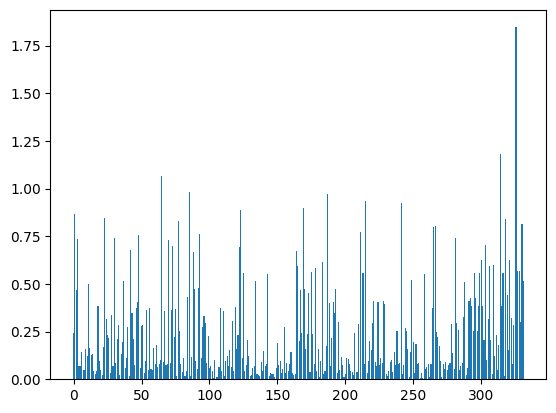

In [146]:
import matplotlib.pyplot as plt
abs_importances = [abs(x) for x in logreg.coef_[0]]
crit_features = {}
# summarize feature importance
for i,v in enumerate(abs_importances):
    # print('Feature: %0d, Score: %.5f Name: %s' % (i,v,cc_apps_train_cat_encoding.columns[i]))
    if v > 0.1:
        crit_features[f'{cc_apps_train_cat_encoding.columns[i]}'] = v
# plot feature importance
plt.bar([x for x in range(len(abs_importances))], abs_importances)
plt.show()

In [147]:
threshold=1
for k, v in crit_features.items():
    if v > threshold:
        print(f'Column {k} has a coefficient {v}')

Column 1_22.50 has a coefficient 1.0649757694483517
Column 5_x has a coefficient 1.1835124072916934
Column 8_f has a coefficient 1.8459110449328715
Column 8_t has a coefficient 1.846000071211416


In [148]:
from sklearn.inspection import permutation_importance

result = permutation_importance(logreg, rescaledX_test, y_test, n_repeats=10, random_state=42)
# print(f'X.columns {len(X.columns)}')
# print(f'result.importances_mean {len(result.importances_mean)}')
# print(f'result.importances_std {len(result.importances_std)}')


feature_importance = pd.DataFrame({'Feature': X.columns[:-2],
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

feature_importance.head()

,Feature,Importance,Standard Deviation
331,12_s,-0.004825,0.003070
88,1_25.00,-0.004825,0.001316
316,6_bb,-0.002193,0.004044
302,5_c,-0.001316,0.003426
309,5_k,-0.000877,0.002632


Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

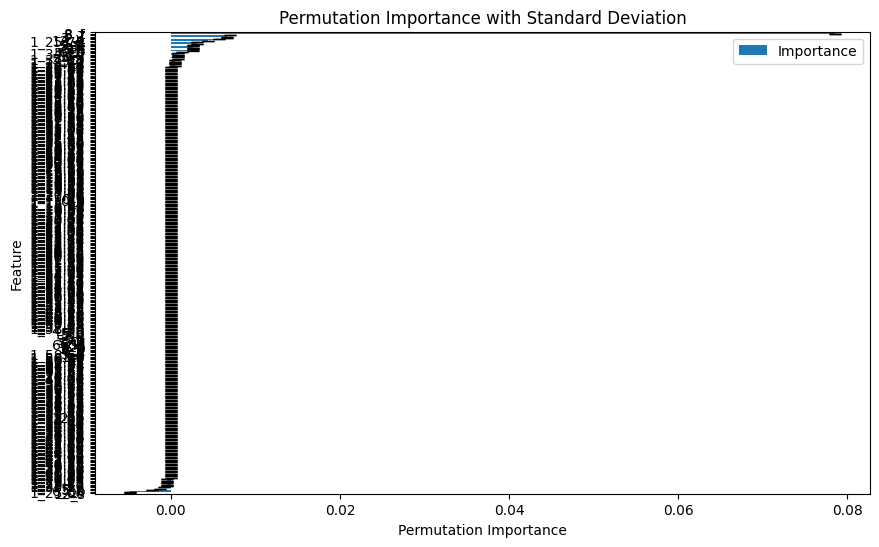

In [149]:
ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')